<a href="https://colab.research.google.com/github/antarleen/Torching-Data/blob/main/ANN_for_Classification_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the libraries**

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Feature Engineering the dataset**

In [2]:
df = pd.read_csv('NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

**Creating a Haversine Function to convert GPS into distance**

In [5]:
def haversine_distance(df,lat1,lat2,long1,long2):
  r = 6371
  phi1 = np.radians(df[lat1])
  phi2 = np.radians(df[lat2])
  lambda1 = np.radians(df[long1])
  lambda2 = np.radians(df[long2])
  delta_phi = phi2 - phi1
  delta_lambda = lambda2 -lambda1
  d = 2 * r * np.arcsin(np.sqrt(np.sin(delta_phi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2))
  return d

In [6]:
df['distance'] = haversine_distance(df,'pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude')

In [7]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


**Fixing the timestamp data to make it more relevant to our application**

In [8]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [9]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [10]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [12]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


In [14]:
df['Hour'] = df['EDTdate'].dt.hour

In [15]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22


In [16]:
df['AMorPM'] = np.where(df['Hour']<12,'AM','PM')
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,AM
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,AM
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,AM
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,PM
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,PM


In [17]:
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,EDTdate,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,AM,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,AM,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,AM,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,PM,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,PM,Fri


In [18]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance', 'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

**Dealing with categorical data**

In [19]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count', 'distance','fare_amount'] 
y_col = ['fare_class']

In [20]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
distance                         float64
EDTdate              datetime64[ns, UTC]
Hour                               int64
AMorPM                            object
Weekday                           object
dtype: object

In [21]:
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [22]:
hr = df['Hour'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values
ampm = df['AMorPM'].cat.codes.values

In [23]:
cats = np.stack([hr,ampm,wkdy],axis=1)
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [24]:
cats = torch.tensor(cats,dtype=torch.int64)

**Dealing with continuous data**

In [25]:
conts = np.stack([df[col].values for col in cont_cols],1)
conts = torch.tensor(conts,dtype=torch.float)
conts

tensor([[-73.9924,  40.7305, -73.9755,  ...,   1.0000,   2.1263,   6.5000],
        [-73.9901,  40.7406, -73.9742,  ...,   1.0000,   1.3923,   6.9000],
        [-73.9941,  40.7511, -73.9601,  ...,   2.0000,   3.3268,  10.1000],
        ...,
        [-73.9886,  40.7498, -74.0115,  ...,   3.0000,   5.0525,  12.5000],
        [-74.0044,  40.7245, -73.9927,  ...,   1.0000,   1.2089,   4.9000],
        [-73.9554,  40.7719, -73.9676,  ...,   3.0000,   1.4274,   5.3000]])

In [73]:
df[y_col] = df[y_col].astype('category')
y = df['fare_class'].cat.codes.values
y = torch.tensor(y,dtype=torch.int64)

In [74]:
cats.shape

torch.Size([120000, 3])

In [75]:
conts.shape

torch.Size([120000, 7])

In [76]:
y.shape

torch.Size([120000])

**Setting the embedding sizes in the categories(One Hot Encoding)**

In [77]:
cat_sizes = [len(df[col].cat.categories) for col in cat_cols]
cat_sizes

[24, 2, 7]

In [78]:
# Emebedding sizes is the number of unique entries divided by two but we max out at 50
emb_sizes = [(size,min(50,(size+1)//2)) for size in cat_sizes]
emb_sizes

[(24, 12), (2, 1), (7, 4)]

# **Creating the ANN Model**

Creating the Embedding layer

In [79]:
class TabularModel(nn.Module):
  def __init__(self,emb_sizes,n_cont,out_size,layers,p=0.5):
    super().__init__()
    self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_sizes])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(n_cont) #Normalizes the continuous data 

    layerlist=[]
    n_embs = sum([nf for ni,nf in emb_sizes])
    n_in = n_embs + n_cont

    for i in layers:
      layerlist.append(nn.Linear(n_in,i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i

    layerlist.append(nn.Linear(layers[-1],out_size))
            
    self.layers = nn.Sequential(*layerlist)
    
  def forward(self,x_cat,x_cont):
    embeddings = []
    for i,e in enumerate(self.embeds):
      embeddings.append(e(x_cat[:,i]))
      
    x = torch.cat(embeddings,1)
    x = self.emb_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x,x_cont],1)
    x = self.layers(x)
    return x
    

# **Training and Testing the Classification Model**

In [80]:
torch.manual_seed(33)
model = TabularModel(emb_sizes,conts.shape[1],2,layers=[200,100],p=0.4) # THE OUTPUT SIZE MUST BE EQUAL TO THE NUMBER OF CLASSES IN THE DATA
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [81]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)


In [97]:
batch_size = 60000
test_size = int(batch_size * 0.2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [98]:
import time
start_time = time.time()
epochs = 300
losses=[]
for i in range(epochs):
  y_pred = model(cat_train,con_train)
  loss = criterion(y_pred,y_train)
  losses.append(loss)
  if i%10 == 1:
    print(f'epoch {i} loss is {loss}')
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

duration = time.time() - start_time
print(f'Triaining took {duration/60} minutes')

epoch 1 loss is 0.011166096664965153
epoch 11 loss is 0.010353384539484978
epoch 21 loss is 0.00923327449709177
epoch 31 loss is 0.009220735169947147
epoch 41 loss is 0.008481609635055065
epoch 51 loss is 0.007997047156095505
epoch 61 loss is 0.006940147373825312
epoch 71 loss is 0.006665842607617378
epoch 81 loss is 0.006123156286776066
epoch 91 loss is 0.0053363386541605
epoch 101 loss is 0.005315874703228474
epoch 111 loss is 0.004910773131996393
epoch 121 loss is 0.0044112480245530605
epoch 131 loss is 0.003979843575507402
epoch 141 loss is 0.0037169787101447582
epoch 151 loss is 0.003242650767788291
epoch 161 loss is 0.002944167470559478
epoch 171 loss is 0.002763675060123205
epoch 181 loss is 0.002567669842392206
epoch 191 loss is 0.002497750334441662
epoch 201 loss is 0.002044881461188197
epoch 211 loss is 0.0018658180488273501
epoch 221 loss is 0.0018807149026542902
epoch 231 loss is 0.001525352941825986
epoch 241 loss is 0.0013150036102160811
epoch 251 loss is 0.00144298875238

**Plotting out the loss function**

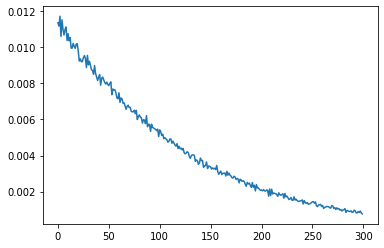

In [99]:
plt.plot(range(epochs),losses)

In [100]:
with torch.no_grad():
  correct = 0
  for i,data in enumerate(cat_test):
    y_val = model(cat_test,con_test)
    loss = criterion(y_val,y_test)
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
    if i%100 == 0:
      print(f'{i+1} -->{str(y_val[i].argmax().item())} ---> {y_test[i]}')
      


1 -->0 ---> 0
101 -->1 ---> 1
201 -->0 ---> 0
301 -->0 ---> 0
401 -->0 ---> 0
501 -->0 ---> 0
601 -->0 ---> 0
701 -->0 ---> 0
801 -->0 ---> 0
901 -->1 ---> 1
1001 -->0 ---> 0
1101 -->0 ---> 0
1201 -->0 ---> 0
1301 -->0 ---> 0
1401 -->0 ---> 0
1501 -->1 ---> 1
1601 -->1 ---> 1
1701 -->1 ---> 1
1801 -->1 ---> 1
1901 -->0 ---> 0
2001 -->1 ---> 1
2101 -->1 ---> 1
2201 -->0 ---> 0
2301 -->0 ---> 0
2401 -->1 ---> 1
2501 -->0 ---> 0
2601 -->0 ---> 0
2701 -->0 ---> 0
2801 -->1 ---> 1
2901 -->1 ---> 1
3001 -->0 ---> 0
3101 -->1 ---> 1
3201 -->1 ---> 1
3301 -->0 ---> 0
3401 -->1 ---> 1
3501 -->0 ---> 0
3601 -->0 ---> 0
3701 -->0 ---> 0
3801 -->0 ---> 0
3901 -->0 ---> 0
4001 -->0 ---> 0
4101 -->0 ---> 0
4201 -->1 ---> 1
4301 -->0 ---> 0
4401 -->0 ---> 0
4501 -->0 ---> 0
4601 -->0 ---> 0
4701 -->1 ---> 1
4801 -->0 ---> 0
4901 -->0 ---> 0
5001 -->1 ---> 1
5101 -->1 ---> 1
5201 -->0 ---> 0
5301 -->1 ---> 1
5401 -->1 ---> 1
5501 -->1 ---> 1
5601 -->0 ---> 0
5701 -->0 ---> 0
5801 -->0 ---> 0
5901 -->1

In [101]:
print(f'{correct } Predictions out of {int(batch_size * 0.2)}!!')

11998 Predictions out of 12000!!


**Saving the model**

In [102]:
torch.save(model.state_dict(),'taxiFareClassModel.pt')